In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
mvc = pd.read_csv("nypd_mvc_2018.csv")

In [ ]:
print(mvc)

In [ ]:
#summary of the columns and their data is below:

# unique_key: A unique identifier for each collision.
# date, time: Date and time of the collision.
# borough: The borough, or area of New York City, where the collision occurred.
# location: Latitude and longitude coordinates for the collision.
# on_street, cross_street, off_street: Details of the street or intersection where the collision occurred.
# pedestrians_injured: Number of pedestrians who were injured.
# cyclist_injured: Number of people traveling on a bicycle who were injured.
# motorist_injured: Number of people traveling in a vehicle who were injured.
# total_injured: Total number of people injured.
# pedestrians_killed: Number of pedestrians who were killed.
# cyclist_killed: Number of people traveling on a bicycle who were killed.
# motorist_killed: Number of people traveling in a vehicle who were killed.
# total_killed: Total number of people killed.
# vehicle_1 through vehicle_5: Type of each vehicle involved in the accident.
# cause_vehicle_1 through cause_vehicle_5: Contributing factor for each vehicle in the accident.

In [7]:
#Counting missing vals recap
data = np.random.choice([1.0, np.nan],
                        size=(3, 3),
                        p=[.3, .7])
df = pd.DataFrame(data, columns=['A','B','C'])
print(df)   #plain df
print(df.isnull()) #show null values
print(df.isnull().sum()) #Show sum of null vals

A    B    C
0  NaN  1.0  1.0
1  1.0  1.0  1.0
2  NaN  1.0  NaN
       A      B      C
0   True  False  False
1  False  False  False
2   True  False   True
A    2
B    0
C    1
dtype: int64


In [10]:
#Find null counts in mvc df
null_counts = mvc.isnull().sum()

In [13]:
#PCT of null vals in each column
null_counts_pct = null_counts / mvc.shape[0] * 100
null_df = pd.DataFrame({'null_counts': null_counts, 'null_pct': null_counts_pct})
# Rotate the dataframe so that rows become columns and vice-versa
null_df = null_df.T.astype(int)
#print(null_df)


In [15]:
#Verifying total Columns
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()

killed_manual_sum = killed.iloc[:,:3].sum(axis=1)

killed_mask = killed_manual_sum != killed['total_killed']
killed_non_eq = killed[killed_mask]
killed_non_eq

,pedestrians_killed,cyclist_killed,motorist_killed,total_killed
3508,0,0,0,NaN
20163,0,0,0,NaN
22046,0,0,1,0.0
48719,0,0,0,NaN
55148,0,0,0,NaN
55699,0,0,0,NaN


In [17]:
#Fixing and verifying killed/injured data

#USEFUL METHOD: Series.mask(bool_mask, val_to_replace)

# fix the killed values
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(), killed_manual_sum)
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

# Create an injured dataframe and manually sum values
injured = mvc[[col for col in mvc.columns if 'injured' in col]].copy()
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'].isnull(), injured_manual_sum)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'] != injured_manual_sum, np.nan)

In [18]:
#Summarizing count of nulls before and after:
summary = {
    'injured': [
        mvc['total_injured'].isnull().sum(),
        injured['total_injured'].isnull().sum()
    ],
    'killed': [
        mvc['total_killed'].isnull().sum(),
        killed['total_killed'].isnull().sum()
    ]
}
print(pd.DataFrame(summary, index=['before','after']))


injured  killed
before        1       5
after        21       0


In [ ]:
#Assigning values from killed & injured back to original df
mvc['total_injured'] = injured['total_injured']
mvc['total_killed'] = killed['total_killed']
                             

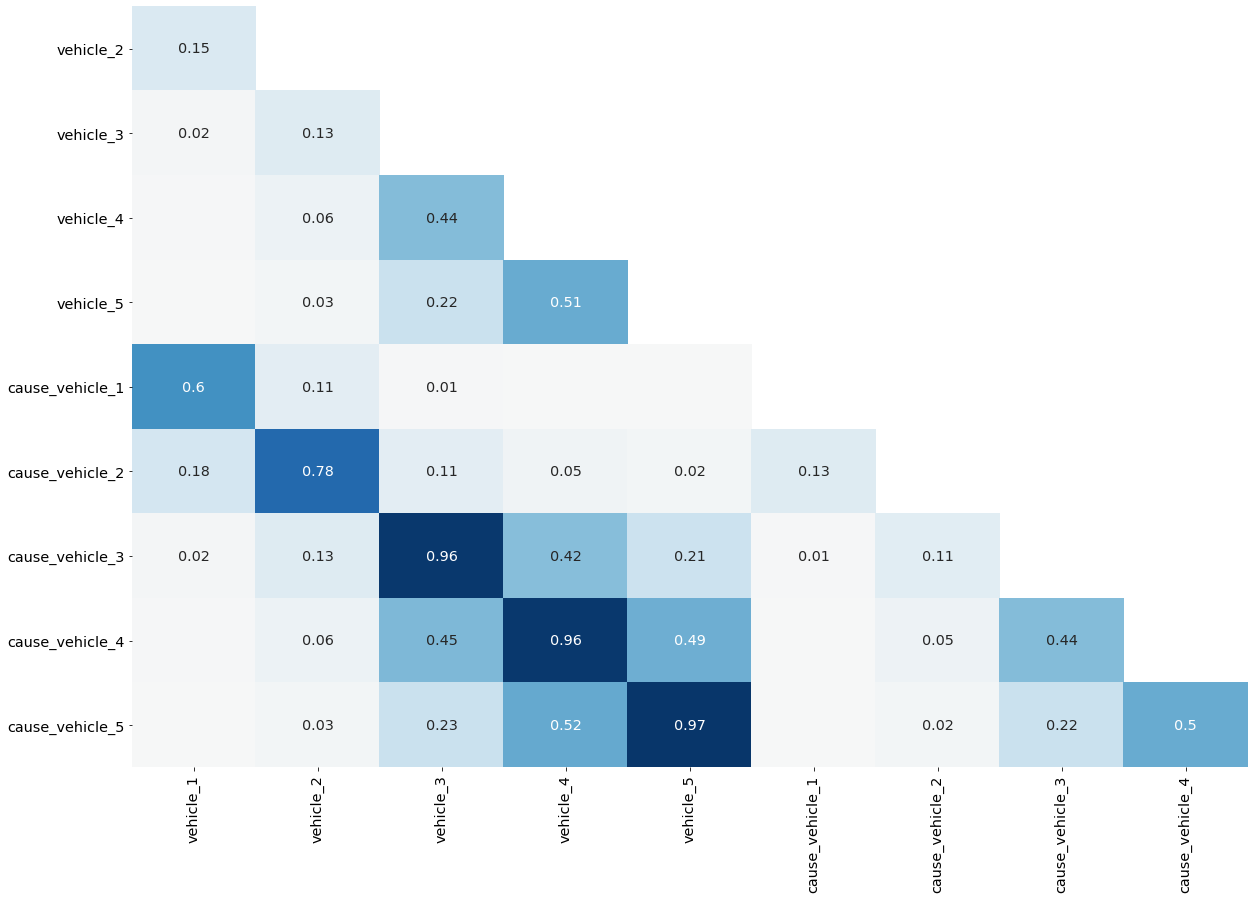

In [21]:
#Visualizing missing data with plots

def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()
    
    

vehicle_cols = [x for x in mvc.columns if 'vehicle' in x]
plot_null_correlations(mvc[vehicle_cols])

In [24]:
#Analyzing COrrelations in missing Data
# col_labels = ['v_number', 'vehicle_missing', 'cause_missing']

vc_null_data = []

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_null = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
    c_null = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()
    
    vc_null_data.append([v, v_null, c_null])
    
vc_null_df = pd.DataFrame(vc_null_data, columns =col_labels)
vc_null_df

,v_number,vehicle_missing,cause_missing
0,1,204,24
1,2,3793,223
2,3,242,24
3,4,50,3
4,5,10,0


In [25]:
#Finding most common values accross multiple columns using stack()

v_cols = [c for c in mvc.columns if c.startswith("vehicle")]

df = mvc[v_cols]
stack = df.stack()
vehicle_counts = stack.value_counts()

top10_vehicles = vehicle_counts.head(10)
